# imports

In [ ]:
from utils import *
from model_utils import *
from data import *
from c2d_models import *

import torch
import torchvision.utils as vutils
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries

# https://github.com/marcoancona/DeepExplain
from deepexplain.tensorflow import DeepExplain
from lime import lime_image

# https://pypi.org/project/keras-explain/
from keras_explain.lrp import LRP
from keras_explain.grad_cam import GradCam
from keras_explain.guided_bp import GuidedBP

Using TensorFlow backend.


# Model

In [ ]:
C2D_MODEL_PATH = "trained_models/C2D_AE_128_3x3_HAM10000/model.h5"

def get_model(rec = True, max_value=1000):
    if rec: model = C2D_AE_128_3x3(isTrain = True)
    else: model = C2D_AE_128_3x3(isTrain = False, max_value = max_value)
    model.model.load_weights(C2D_MODEL_PATH)
    return model.model

# c2d_model_prb = get_model(False)
# c2d_model_rec = get_model(True)

# Data

In [3]:
IR_TEST_DIR = "TEST_SETS/HAM10000/"

test_dict = dict()
for class_dir in read_directory_contents(IR_TEST_DIR):
    test_dict[class_dir.split("/")[-1]] = np.array([read_image(file) for file in read_directory_contents(class_dir)])
#     test_dict[class_dir.split("/")[-1]] = np.array([read_image(file, resize_to=(128,128))/255. for file in read_directory_contents(class_dir)])
    
# 1 -> High Loss -> Anomaly
# 0 -> Low Loss -> Normal
X_test = list()
y_test = list()
for key in set(test_dict.keys()):
    X_test.append(test_dict[key])
    y_test += [0 if "normal" in key else 1]*len(test_dict[key])
X_test = np.concatenate(X_test)
y_test = np.array(y_test)

In [4]:
X_test[0].shape

(128, 128, 3)

In [5]:
xai_results = dict()

In [5]:
de_methods = {
    "Gradient_Inputs": "grad*input",
    "Saliency": "saliency",
    "Integrated_Gradients": "intgrad",
    "DeepLIFT": "deeplift",
    "e-LRP": "elrp",
    "Occlusion": "occlusion"
}

In [ ]:
with DeepExplain(session=K.get_session()) as de:
    model = get_model(True)
    input_tensor = model.layers[0].input
    de_model = Model(inputs=input_tensor, outputs = model.layers[-1].output)
    target_tensor = de_model(input_tensor)

    for method_name, method_tag in de_methods.items():
        print("-"*40)
        print("Method: %s"%method_name)
        print("-"*40)
        try: attributions = de.explain(method_tag, target_tensor, input_tensor, X_test, ys=X_test, batch_size = 64) # np.expand_dims(y_test, axis = -1))
        except Exception as e: 
            print("ERROR:", e)
            continue
        xai_results[method_name] = attributions

#     print("-"*40)
#     print("Method: %s"%method_name)
#     print("-"*40)
#     try: xai_results["Shapely"] = de.explain('shapley_sampling', target_tensor, input_tensor, X_test, ys=X_test, samples=2, sampling_dims=[1,2,3])
#     except Exception as e: print("ERROR:", e)

# LIME

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


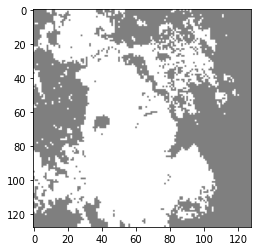

In [15]:
plt.imshow(temp / 2 +0.5)

In [30]:
lime_explainer = lime_image.LimeImageExplainer()

model = get_model(False)

lime_results = list()
for xs in X_test:
    lime_explanation = lime_explainer.explain_instance(xs.astype('double'), model.predict, num_features=128*128, batch_size = 32,)
    temp, mask = lime_explanation.get_image_and_mask(lime_explanation.top_labels[0], positive_only=True, num_features=10, hide_rest=False)
    temp = normalize(temp)
    result_mask = mark_boundaries(temp / 2 + 0.5, mask)
    lime_results.append(result_mask)
    break
lime_results = np.array(lime_results)

xai_results["LIME"] = lime_results

In [27]:
temp.min(), temp.max()

(64.0, 242.0)

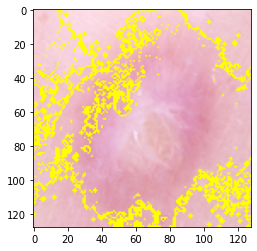

In [32]:
plt.imshow(mark_boundaries(normalize(temp) / 2 + 0.5, mask))

In [33]:
isinstance(xs, np.ndarray)

True

# LRP, GuidedBP, GradCAM

# remove /tmp/checkpoint and all other keras files in /tmp/ if GuidedBP isnt working

In [4]:
model = get_model(True)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [29]:
ke_methods = {
    "GuidedBP": GuidedBP(model),
    "GradCAM": GradCam(model, layer = -2),
}

In [30]:
k_explainer_results = dict([(key, list()) for key in list(ke_methods.keys())])

for method, explainer in ke_methods.items():
    for xs in X_test:
        exp = explainer.explain(xs, 1)
        k_explainer_results[method].append(normalize(exp[0]))
        
for key in k_explainer_results.keys():
    xai_results[key] = np.array(k_explainer_results[key])

# SHAP

In [16]:
from _shap import *

In [17]:
ir_train = IR_DISTRACTION()
X_train = ir_train.data

In [18]:
model = get_model(False)

In [19]:
se = SHAP_Explainer()
shap_out = se.explain(model, X_train, X_test)
xai_results["SHAP"] = shap_out

# Save results

In [33]:
print(xai_results.keys())
dump_pickle(xai_results, "results/xai_results.pkl")

True

In [34]:
exit()